Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1009 entries, 0 to 1008
Columns: 125 entries, SubjectID to Date
dtypes: float64(119), object(6)
memory usage: 985.5+ KB
None

Missing values:
SubjectID       0
unnamed_1    1009
T_offset1      54
Max1R13_1      53
Max1L13_1      53
             ... 
Humidity        0
Distance        2
Cosmetics      32
Time            0
Date            0
Length: 125, dtype: int64
Binning 0.001 GB of training data: 0.041 s
Fitting gradient boosted rounds:
Fit 1000 trees in 1.040 s, (11119 total leaves)
Time spent computing histograms: 0.235s
Time spent finding best splits:  0.250s
Time spent applying splits:      0.126s
Time spent predicting:           0.015s
Mean Squared Error: 0.0684
Root Mean Squared Error: 0.2615
R-squared Score: 0.5390


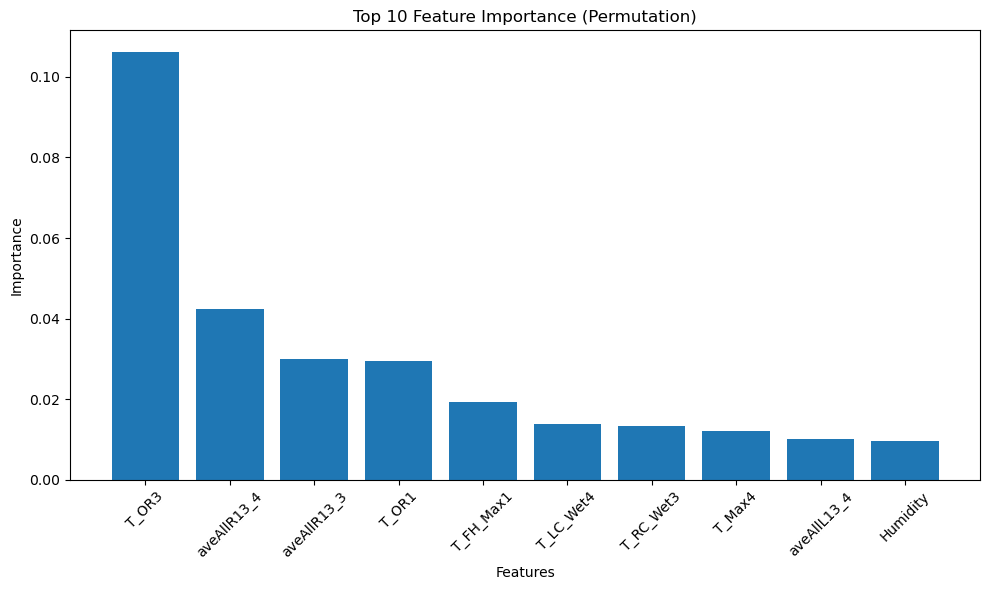


Top 10 Most Important Features:
         Feature  Importance
82         T_OR3    0.106205
88   aveAllR13_4    0.042399
60   aveAllR13_3    0.030046
26         T_OR1    0.029445
23     T_FH_Max1    0.019275
96     T_LC_Wet4    0.013913
64     T_RC_Wet3    0.013464
109       T_Max4    0.012117
89   aveAllL13_4    0.010070
117     Humidity    0.009584


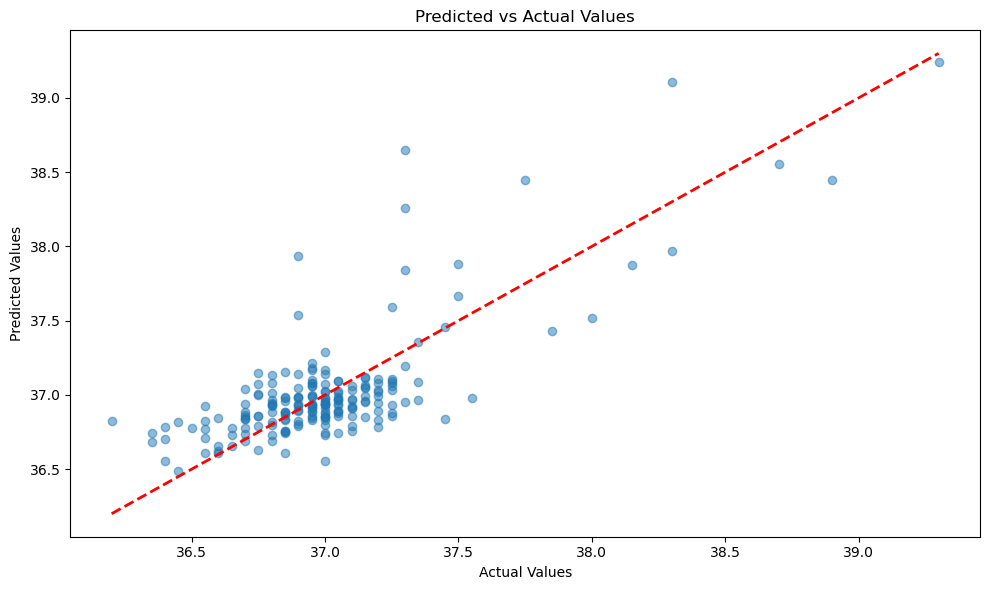

In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.inspection import permutation_importance  # Added for feature importance
import matplotlib.pyplot as plt

# Load and fix the dataset
file_path = r"ICI_groups1and2.csv"
try:
    df = pd.read_csv(file_path)
except FileNotFoundError:
    print(f"Error: File not found at {file_path}")
    print("Please verify the file path and ensure the CSV file exists in that location")
    exit()

# Set column names from row 1 and handle duplicates
df.columns = df.iloc[1]
df = df.drop([0, 1]).reset_index(drop=True)

# Handle column names
columns = []
seen = {}
for col in df.columns:
    if pd.isna(col) or col == 'nan':
        col = f"unnamed_{len(seen)}"
    if col in seen:
        seen[col] += 1
        columns.append(f"{col}_{seen[col]}")
    else:
        seen[col] = 0
        columns.append(col)
df.columns = columns

# Convert numeric columns
categorical_cols = ['SubjectID', 'Gender', 'Ethnicity', 'Cosmetics', 'Time', 'Date']
numeric_columns = [col for col in df.columns if col not in categorical_cols]
df[numeric_columns] = df[numeric_columns].apply(pd.to_numeric, errors='coerce')

# Display basic information
print("Dataset Info:")
print(df.info())
print("\nMissing values:")
print(df.isnull().sum())

# Data Preprocessing
target = 'aveOralF'
features = [col for col in df.columns if col not in ['aveOralF', 'aveOralM', 'SubjectID', 'Time', 'Date']]

# Handle categorical variables
categorical_features = ['Gender', 'Ethnicity', 'Cosmetics']
for col in categorical_features:
    df[col] = df[col].astype('category')

# Handle missing values
df[numeric_columns] = df[numeric_columns].fillna(df[numeric_columns].mean())

# Split features and target
X = df[features]
y = df[target]

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Initialize and train the HistGradientBoosting model
model = HistGradientBoostingRegressor(
    max_iter=1000,
    learning_rate=0.1,
    max_depth=6,
    random_state=42,
    categorical_features=[X.columns.get_loc(col) for col in categorical_features],
    verbose=1
)

# Train the model
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse:.4f}")
print(f"Root Mean Squared Error: {rmse:.4f}")
print(f"R-squared Score: {r2:.4f}")

# Feature Importance using permutation importance
perm_importance = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42)
feature_names = X_train.columns

feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': perm_importance.importances_mean
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.bar(feature_importance_df['Feature'][:10], feature_importance_df['Importance'][:10])
plt.xticks(rotation=45)
plt.title('Top 10 Feature Importance (Permutation)')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.tight_layout()
plt.show()

print("\nTop 10 Most Important Features:")
print(feature_importance_df.head(10))

# Plot predicted vs actual values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Predicted vs Actual Values')
plt.tight_layout()
plt.show()